### Imports

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.kernel_approximation import Nystroem
import matplotlib.pyplot as plt 
import numpy as np

### NTK

#### NTK Class

In [52]:
class NTK(Kernel):
    def __init__(
        self, 
        depth, 
        c=2.0
    ):
        self.depth = depth
        self.c = c

    # Need's rewrite -> 2007.01580 uses x,z in R^d not whole matricies
    # sigma_0(X,Z) = X @ Z.T -> usually vector x vector = scaler
    #                        -> but with n x m 
    def __call__(self, X, Z=None, eval_gradient=False):
        aug = False
        X_shape = -1
        Z_shape = -1

        if Z is None:
            Z = X
        else:
            X_shape = X.shape[0]
            Z_shape = Z.shape[0]
            A = np.concatenate((X, Z), axis=0)
            X = A 
            Z = A
            aug = True
            
        Σ_mat = X @ Z.T
        Σ_mat_dot = np.zeros_like(Σ_mat)
        K = np.zeros((self.depth+1, X.shape[0], Z.shape[0]))
        K[0] = Σ_mat

        D = np.sqrt((X @ X.T) * (Z @ Z.T))
        
        # What's a good way to add ~0 noise to the denominator here?
        for dep in range(1, self.depth+1):
            diag = np.diag(Σ_mat) + 1e-10
            denominator = np.sqrt(np.outer(diag, diag))
            λ = np.clip(Σ_mat / denominator, a_min=-1, a_max=1)
            Σ_mat = (self.c / (2 * np.pi)) * (λ * (np.pi - np.arccos(λ)) + np.sqrt(1 - λ**2)) * denominator
            Σ_mat_dot = (self.c / (2 * np.pi)) * (np.pi - np.arccos(λ))
            K[dep] = K[dep-1] * Σ_mat_dot + Σ_mat

        if eval_gradient:
            # K_gradient = np.gradient(K) #?
            return K[self.depth], np.empty((X.shape[0], X.shape[0], 0))
        else:
            if aug:
                return (1/self.depth) * K[self.depth, 0:X_shape, X_shape:(X_shape + Z_shape)]
            else:
                return (1/self.depth) * K[self.depth]
        
        # return K

    def diag(self, X):
        return np.einsum("ij,ij->i", X, X)

    def is_stationary(self):
        """Returns whether the kernel is stationary."""
        return False

    def __repr__(self):
        return "{0}(depth={1:d}, c={2:.3f})".format(
                self.__class__.__name__, self.depth, self.c)

In [54]:
neural_tangent_kernel = (
    NTK(depth=20, c=2)
)

gp_ntk = GPR(kernel=neural_tangent_kernel, alpha=1e-6, n_restarts_optimizer=9)


X = np.array([1,2,3,4,5]).reshape(-1,1)
Z = np.array([-1, 3]).reshape(-1, 1)

gp_ntk.kernel(X, Z)

array([[ 0.30997384,  3.14989431],
       [ 0.61994768,  6.29987949],
       [ 0.92992152,  9.4498582 ],
       [ 1.23989535, 12.59983289],
       [ 1.54986919, 15.74980512]])

#### NTK Function

In [3]:
"""
Neural Tangent Kernel Precompute
https://github.com/LeoYu/neural-tangent-kernel-UCI/
"""
def ntk_value(X, d_max, fix_dep): 
    K = np.zeros((d_max, X.shape[0], X.shape[0]))
    Σ_mat = np.matmul(X, X.T)
    Σ_mat_dot = np.zeros_like(Σ_mat)
    for dep in range(d_max):
        if fix_dep <= dep:
            Σ_mat_dot += Σ_mat
        K[dep] = Σ_mat_dot
        L = np.diag(Σ_mat)
        P = np.clip(np.sqrt(np.outer(L, L)), a_min = 1e-9, a_max = None)
        λ = np.clip(Σ_mat / P, a_min = -1, a_max = 1)
        Σ_mat = (λ * (math.pi - np.arccos(λ)) + np.sqrt(1.0 - λ * λ)) * P / 2.0 / math.pi
        Σ_mat_dot = Σ_mat_dot * (math.pi - np.arccos(λ)) / 2.0 / math.pi
    return K[d_max - 1]

## 3D Function

### Dataset

In [99]:
z = np.linspace(-2, 2, 100)
x = (z**2 + 1) * np.sin(np.linspace(-np.pi, np.pi, 100))
y = (z**2 + 1) * np.cos(np.linspace(-np.pi, np.pi, 100))

X = np.stack((x, y), axis=1)
z = z.reshape((-1, 1))

In [100]:
X_train, X_test, z_train, z_test = train_test_split(
    X, z, test_size=0.5, random_state=624562)

### Gaussian Process - Noiseless

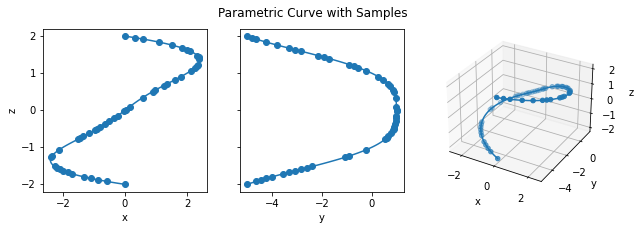

In [101]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True ,figsize=(10, 3), gridspec_kw={'width_ratios' : [1, 1, 1]})
ax3.remove()
ax3 = fig.add_subplot(1,3,3, projection='3d')

ax1.plot(X[:,0], z)
ax1.scatter(X_train[:,0], z_train)
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax2.plot(X[:,1], z)
ax2.scatter(X_train[:,1], z_train)
ax2.set_xlabel('y')
ax3.plot(X[:,0], X[:,1], z.ravel())
ax3.scatter(X_train[:,0], X_train[:,1], z_train)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
_ = fig.suptitle("Parametric Curve with Samples")

In [102]:
X_train_norm = X_train #normalize(X_train)
z_train_norm = z_train #normalize(z_train)

X_norm = X #normalize(X)
z_norm = z #normalize(z)

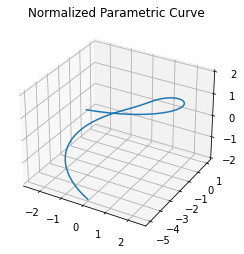

In [103]:

fig = plt.figure(); ax = fig.add_subplot(projection='3d')
ax.plot(X_norm[:,0], X_norm[:,1], z.ravel())
_=ax.set_title("Normalized Parametric Curve")

In [104]:
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=2) #+ 
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_ntk = GPR(kernel=neural_tangent_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_ntk.fit(X_train_norm, z_train_norm)

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e10)) * 
    Matern(length_scale_bounds=(2e-2*(1/2), 1/2), nu=1/2) #+
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_lpk = GPR(kernel=laplace_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_lpk.fit(X_train_norm, z_train_norm)

print('NTK     : ', gp_ntk.kernel_, '\nLaplace : ', gp_lpk.kernel_)

NTK     :  0.197**2 * NTK(depth=2, c=2.000) 
Laplace :  1e+05**2 * Matern(length_scale=0.01, nu=0.5)


/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [105]:
mean_ntk = gp_ntk.predict(X_norm)
mean_lpk = gp_lpk.predict(X_norm)

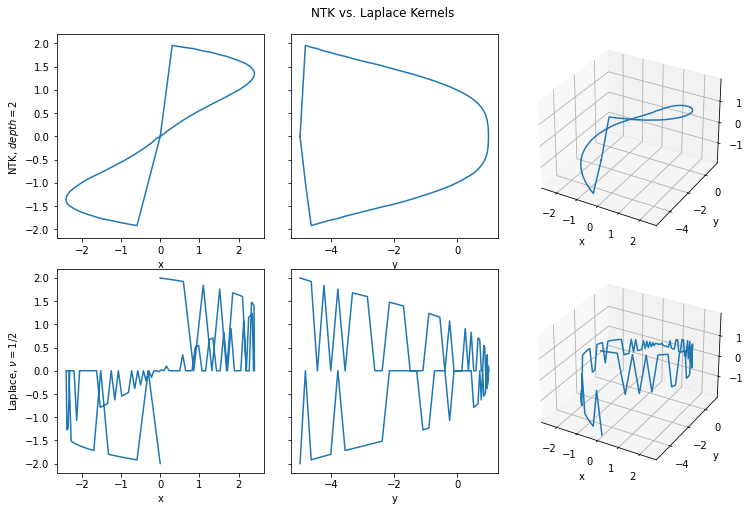

In [106]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharey=True ,figsize=(10, 7), gridspec_kw={'width_ratios' : [1, 1, 1]})
ax = ax.ravel()
ax[2].remove()
ax[2] = fig.add_subplot(2,3,3, projection='3d')
ax[5].remove()
ax[5] = fig.add_subplot(2,3,6, projection='3d')
fig.tight_layout()
fig.subplots_adjust(top=.925)

ax[0].plot(X_norm[:,0], mean_ntk.ravel())
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'NTK, $depth=2$')
ax[1].plot(X_norm[:,1], mean_ntk.ravel())
ax[1].set_xlabel('y')
ax[2].plot(X_norm[:,0], X_norm[:,1], mean_ntk.ravel())
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')

ax[3].plot(X_norm[:,0], mean_lpk.ravel())
ax[3].set_xlabel('x')
ax[3].set_ylabel(r'Laplace, $\nu = 1/2$')
ax[4].plot(X_norm[:,1], mean_lpk.ravel())
ax[4].set_xlabel('y')
ax[5].plot(X_norm[:,0], X_norm[:,1], mean_lpk.ravel())
ax[5].set_xlabel('x')
ax[5].set_ylabel('y')

_=fig.suptitle("NTK vs. Laplace Kernels")

### Gaussian Process - Noisy

In [28]:
X_train_noisy = np.random.normal(X_train, scale=0.15)
z_train_noisy = np.random.normal(z_train, scale=0.15)

# X_noisy = np.random.normal(X, scale=0.15)
X_noisy = X

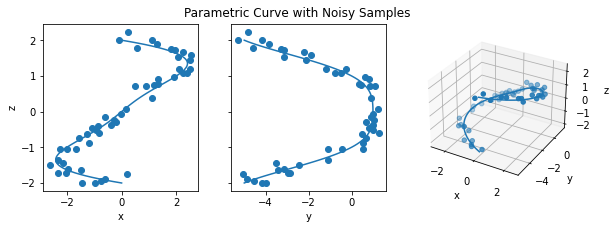

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharey=True ,figsize=(8, 3), gridspec_kw={'width_ratios' : [1, 1, 1]})
ax3.remove()
ax3 = fig.add_subplot(1,3,3, projection='3d')
fig.tight_layout()
fig.subplots_adjust(top=.9)

ax1.plot(X[:,0], z)
ax1.scatter(X_train_noisy[:,0], z_train_noisy)
ax1.set_xlabel('x')
ax1.set_ylabel('z')
ax2.plot(X[:,1], z)
ax2.scatter(X_train_noisy[:,1], z_train_noisy)
ax2.set_xlabel('y')
ax3.plot(X[:,0], X[:,1], z.ravel())
ax3.scatter(X_train_noisy[:,0], X_train_noisy[:,1], z_train_noisy)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('z')
_ = fig.suptitle("Parametric Curve with Noisy Samples")

In [30]:
X_train_noisy_norm = normalize(X_train_noisy)
z_train_noisy_norm = normalize(z_train_noisy)

X_noisy_norm = normalize(X_noisy)

In [67]:
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=2) + 
    WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_ntk_noisy = GPR(kernel=neural_tangent_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_ntk_noisy.fit(X_train_noisy_norm, z_train_noisy_norm)

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e10)) * 
    Matern(length_scale_bounds=(2e-10, 1e5), nu=1/2) +
    WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_lpk_noisy = GPR(kernel=laplace_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_lpk_noisy.fit(X_train_noisy_norm, z_train_noisy_norm)

print('NTK     : ', gp_ntk_noisy.kernel_, '\nLaplace : ', gp_lpk_noisy.kernel_)

NTK     :  0.517**2 * NTK(depth=2, c=2.000) + WhiteKernel(noise_level=0.133) 
Laplace :  1.18**2 * Matern(length_scale=3.59, nu=0.5) + WhiteKernel(noise_level=0.125)


In [68]:
# Predict on noisy dataset
mean_ntk_noisy = gp_ntk_noisy.predict(X_noisy_norm)
mean_lpk_noisy = gp_lpk_noisy.predict(X_noisy_norm)

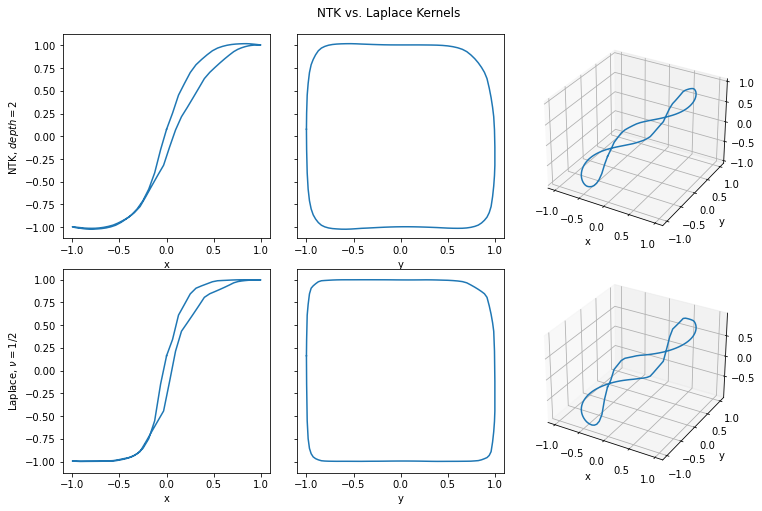

In [69]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharey=True ,figsize=(10, 7), gridspec_kw={'width_ratios' : [1, 1, 1]})
ax = ax.ravel()
ax[2].remove()
ax[2] = fig.add_subplot(2,3,3, projection='3d')
ax[5].remove()
ax[5] = fig.add_subplot(2,3,6, projection='3d')
fig.tight_layout()
fig.subplots_adjust(top=.925)

ax[0].plot(X_noisy_norm[:,0], mean_ntk_noisy.ravel())
ax[0].set_xlabel('x')
ax[0].set_ylabel(r'NTK, $depth=2$')
ax[1].plot(X_noisy_norm[:,1], mean_ntk_noisy.ravel())
ax[1].set_xlabel('y')
ax[2].plot(X_noisy_norm[:,0], X_noisy_norm[:,1], mean_ntk_noisy.ravel())
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')

ax[3].plot(X_noisy_norm[:,0], mean_lpk_noisy.ravel())
ax[3].set_xlabel('x')
ax[3].set_ylabel(r'Laplace, $\nu = 1/2$')
ax[4].plot(X_noisy_norm[:,1], mean_lpk_noisy.ravel())
ax[4].set_xlabel('y')
ax[5].plot(X_noisy_norm[:,0], X_noisy_norm[:,1], mean_lpk_noisy.ravel())
ax[5].set_xlabel('x')
ax[5].set_ylabel('y')

_=fig.suptitle("NTK vs. Laplace Kernels")

### Sample Paths

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:478: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(y_mean[:, i], y_cov, n_samples).T[:, np.newaxis]


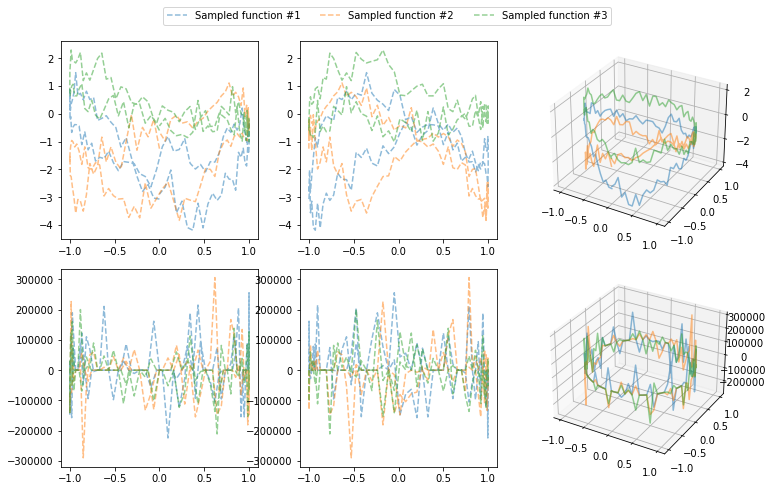

In [59]:
gp_ntk_sample = GPR(kernel=neural_tangent_kernel)
mean_ntk_sample = gp_ntk_sample.predict(X_norm)
samples_ntk = gp_ntk_sample.sample_y(X_norm, 3)

gp_lpk_sample = GPR(kernel=laplace_kernel)
mean_lpk_sample = gp_lpk_sample.predict(X_norm)
samples_lpk = gp_lpk.sample_y(X_norm, 3)
samples_lpk = np.squeeze(samples_lpk)


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,7))
ax = ax.ravel()
ax[2].remove()
ax[2] = fig.add_subplot(2,3,3, projection='3d')
ax[5].remove()
ax[5] = fig.add_subplot(2,3,6, projection='3d')
fig.tight_layout()
fig.subplots_adjust(top=.9)

for i, prior in enumerate(samples_ntk.T):
    ax[0].plot(X_norm[:,0], prior, linestyle="--", alpha=0.5, label=f"Sampled function #{i + 1}")
    ax[1].plot(X_norm[:,1], prior, linestyle="--", alpha=0.5)
    ax[2].plot(X_norm[:,0], X_norm[:,1], prior, alpha=0.5)

for i, prior in enumerate(samples_lpk.T):
    ax[3].plot(X_norm[:,0], prior, linestyle="--", alpha=0.5)
    ax[4].plot(X_norm[:,1], prior, linestyle="--", alpha=0.5)
    ax[5].plot(X_norm[:,0], X_norm[:,1], prior, alpha=0.5)

fig.legend(bbox_to_anchor=(0, .85, 1, 0.2), loc='center', ncol=3)

## 2D Function

### Dataset

In [79]:
x_2d = np.linspace(0, 2*np.pi).reshape(-1, 1)
y_2d = 1/2 * x_2d
y_2d_noisy = np.random.normal(y_2d, scale=0.15)


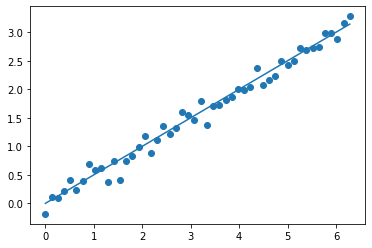

In [80]:
fig, ax = plt.subplots()
ax.plot(x_2d, y_2d)
ax.scatter(x_2d, y_2d_noisy)

In [88]:
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=2) #+ 
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_ntk2d = GPR(kernel=neural_tangent_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_ntk_2d.fit(x_2d, y_2d_noisy)

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e10)) * 
    Matern(length_scale_bounds=(2e-10, 1e5), nu=1/2) #+
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_lpk_2d = GPR(kernel=laplace_kernel, alpha=1e-6, n_restarts_optimizer=9)
gp_lpk_2d.fit(x_2d, y_2d_noisy)

print('NTK     : ', gp_ntk_noisy.kernel_, '\nLaplace : ', gp_lpk_noisy.kernel_)

NTK     :  0.517**2 * NTK(depth=2, c=2.000) + WhiteKernel(noise_level=0.133) 
Laplace :  1.18**2 * Matern(length_scale=3.59, nu=0.5) + WhiteKernel(noise_level=0.125)


In [82]:
mean_ntk_2d = gp_ntk_2d.predict(x_2d)
mean_lpk_2d = gp_lpk_2d.predict(x_2d)

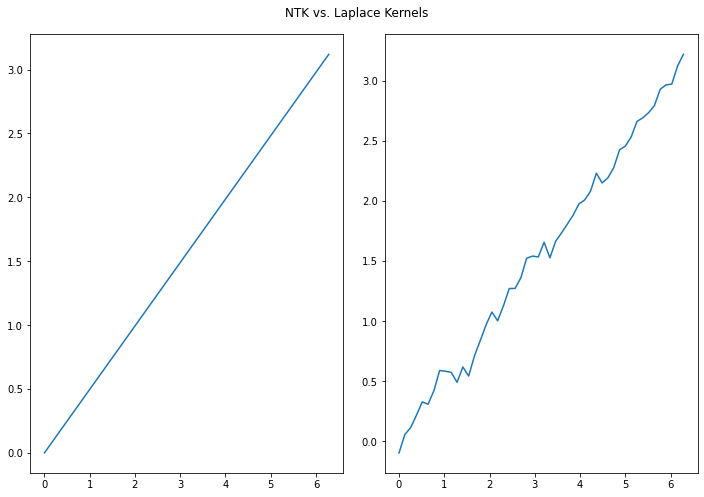

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 7), gridspec_kw={'width_ratios' : [1, 1]})
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.925)

ax[0].plot(x_2d, mean_ntk_2d.ravel())
ax[1].plot(x_2d, mean_lpk_2d.ravel())

_=fig.suptitle("NTK vs. Laplace Kernels")

### Sample Paths

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:478: RuntimeWarning: covariance is not positive-semidefinite.
  rng.multivariate_normal(y_mean[:, i], y_cov, n_samples).T[:, np.newaxis]


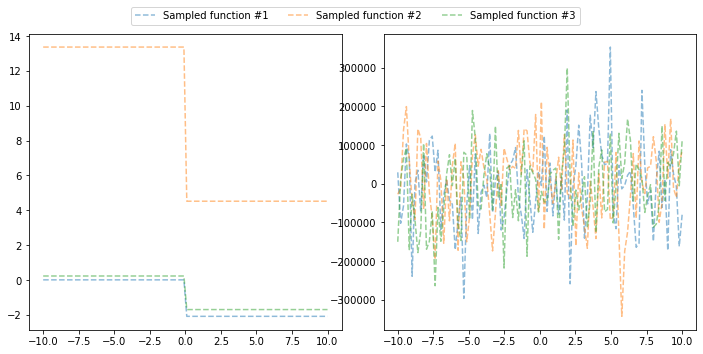

In [96]:
t = np.linspace(-10, 10, 100)
# t = np.exp(t)
T = t.reshape(-1,1)
T = normalize(T)

n_samples = 3

neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=2, c=10) #+ 
    # WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)

gp_ntk_sample = GPR(kernel=neural_tangent_kernel)
mean_ntk_sample = gp_ntk_sample.predict(T)
samples_ntk = gp_ntk_sample.sample_y(T, n_samples, random_state=np.random.randint(1000000000))
samples_ntk = np.squeeze(samples_ntk)

gp_lpk_sample = GPR(kernel=laplace_kernel)
mean_lpk_sample = gp_lpk_sample.predict(T)
samples_lpk = gp_lpk.sample_y(np.stack((t,t),axis=1), n_samples, random_state=np.random.randint(1000000000))
samples_lpk = np.squeeze(samples_lpk)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = ax.ravel()
fig.tight_layout()
fig.subplots_adjust(top=.9)

for i, prior in enumerate(samples_ntk.T):
    ax[0].plot(t, prior, linestyle="--", alpha=0.5, label=f"Sampled function #{i + 1}")

for i, prior in enumerate(samples_lpk.T):
    ax[1].plot(t, prior, linestyle="--", alpha=0.5)

# ax[0].plot(t, samples_ntk, linestyle="--", alpha=0.5, label="Sampled function")
# ax[1].plot(t, samples_lpk, linestyle="--", alpha=0.5)

fig.legend(bbox_to_anchor=(0, .85, 1, 0.2), loc='center', ncol=3)